# Table E5
## Linear Regression with image-expression axes (IEAs) and COPD measurements with 1,527 subjects from another subset of the COPDGene dataset that had not been used for model training.  
The table reports the β coefficients of linear regression models for estimating the cross-sectional and longitudinal measurements. The values in the brackets are the 95% confidence interval of the β coefficients. 

In [1]:
import numpy as np
import sys
sys.path.append("../../src/")
import utility
import pandas as pd

from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import ttest_ind

from scipy.stats import kruskal
from statsmodels.stats.proportion import proportions_chisquare

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib

import statsmodels.api as sm

from scipy import stats

import pandas as pd

import math


In [2]:
df_IEA_train = pd.read_csv("../../output/IEA_train.csv").set_index("sid")
df_IEA_test = pd.read_csv("../../output/IEA_test.csv").set_index("sid")

df_IEA_P2 = pd.read_csv("../../output/IEA_P2.csv").set_index("sid")



In [3]:
sid_used = [iii for iii in df_IEA_P2.index if iii not in df_IEA_train.index and iii not in df_IEA_test.index]

df_IEA = df_IEA_P2[ df_IEA_P2.index.isin(sid_used) ]

In [4]:
df = utility.load_data()

df_used = pd.merge(df, df_IEA, left_index = True, right_index = True)

/ocean/projects/asc170022p/juc91/anaconda/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/ocean/projects/asc170022p/juc91/anaconda/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/ocean/projects/asc170022p/juc91/anaconda/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

# Regression with Both IEAs and covariates

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [6]:
independents = ["IEA0", "IEA1", 
       "Age_P2", "gender", 'race', 'ATS_PackYears_P2', "smoking_status_P2",
           ]

dependents = ['BMI_P2', 'FEV1pp_utah_P2', 'FEV1_FVC_utah_P2', 'SGRQ_scoreTotal_P2', "MMRCDyspneaScor_P2", 'distwalked_P2',
              
              
              'Perc15_Insp_Thirona_P2',
              'pctEmph_Thirona_P2',
              'pctGasTrap_Thirona_P2',
              'Pi10_Thirona_P2',
              'WallAreaPct_seg_Thirona_P2',
              'perc15_ratio',

              
              'delta_FEV1pp_P2P3', "delta_FEV1FVC_P2P3",
           ]

models_IEA = []
cov_dict_IEA = {iii:[] for iii in independents}

In [7]:
X = df_used[independents]
X_used = X[~X.isnull().any(1)]

In [8]:
for ccc in dependents:
    X = df_used[independents]
        
    y = df_used[ccc]
    idx = np.bitwise_and(~np.isnan(y), ~np.isnan(X).any(1))
    
    X = X[idx]
    y = y[idx].astype(float)
    
    X = sm.add_constant(X.apply(stats.zscore))
    y = stats.zscore(y)
    
    
    M_OLS = sm.OLS(y, X).fit()

    models_IEA.append(M_OLS)

    
    v = M_OLS.summary2().tables[1].values
    
    
    for iii in range(1, len(independents) + 1):
        col = independents[iii-1]
        eee = "{:.2f}".format(v[iii, 0])
        ppp = v[iii, 3]
        if ppp<.05:
            eee += "*"
        if ppp<.01:
            eee += "*"
        if ppp<.001:
            eee += "*"
            
        CI1 = "({:.2f}, {:.2f})".format(v[iii, 4], v[iii, 5])
        
        cov_dict_IEA[col].append("'" + eee + "\n" + CI1)

# Table for beta coeffcients 

In [9]:
rows = ["FEV$_1$ %predicted", "FEV$_1$ / FVC", "SGRQ Total Score", "mMRC Dyspnea Score", "6-Minute-Walk Distance", 

        "Body Mass Index (BMI)",
        "perc15",
        "%Emphysema at -950HU",
        "%Gas trapping",
        "Pi10",
        "%WA segmental",
        "$Q_{perc15_{peel-core}}$",
        
        
        "$\Delta$FEV$_1$ %predicted", "$\Delta$FEV$_1$/FVC"
       ]



In [10]:
independents = ["IEA0", "IEA1", 
       "Age_P2", "gender", 'race', 'ATS_PackYears_P2', "smoking_status_P2",
]

cov_label = [ 'IEAemph', 'IEAairway', 'Age',
 'Gender,\n%females', 'Race, \n%African-American',
 'Pack Years', 
 'Smoking Status', 
            ]

In [11]:
table = np.array( [ [cov_dict_IEA[ccc][iii] for ccc in independents] for iii in range(len(models_IEA))  ] )

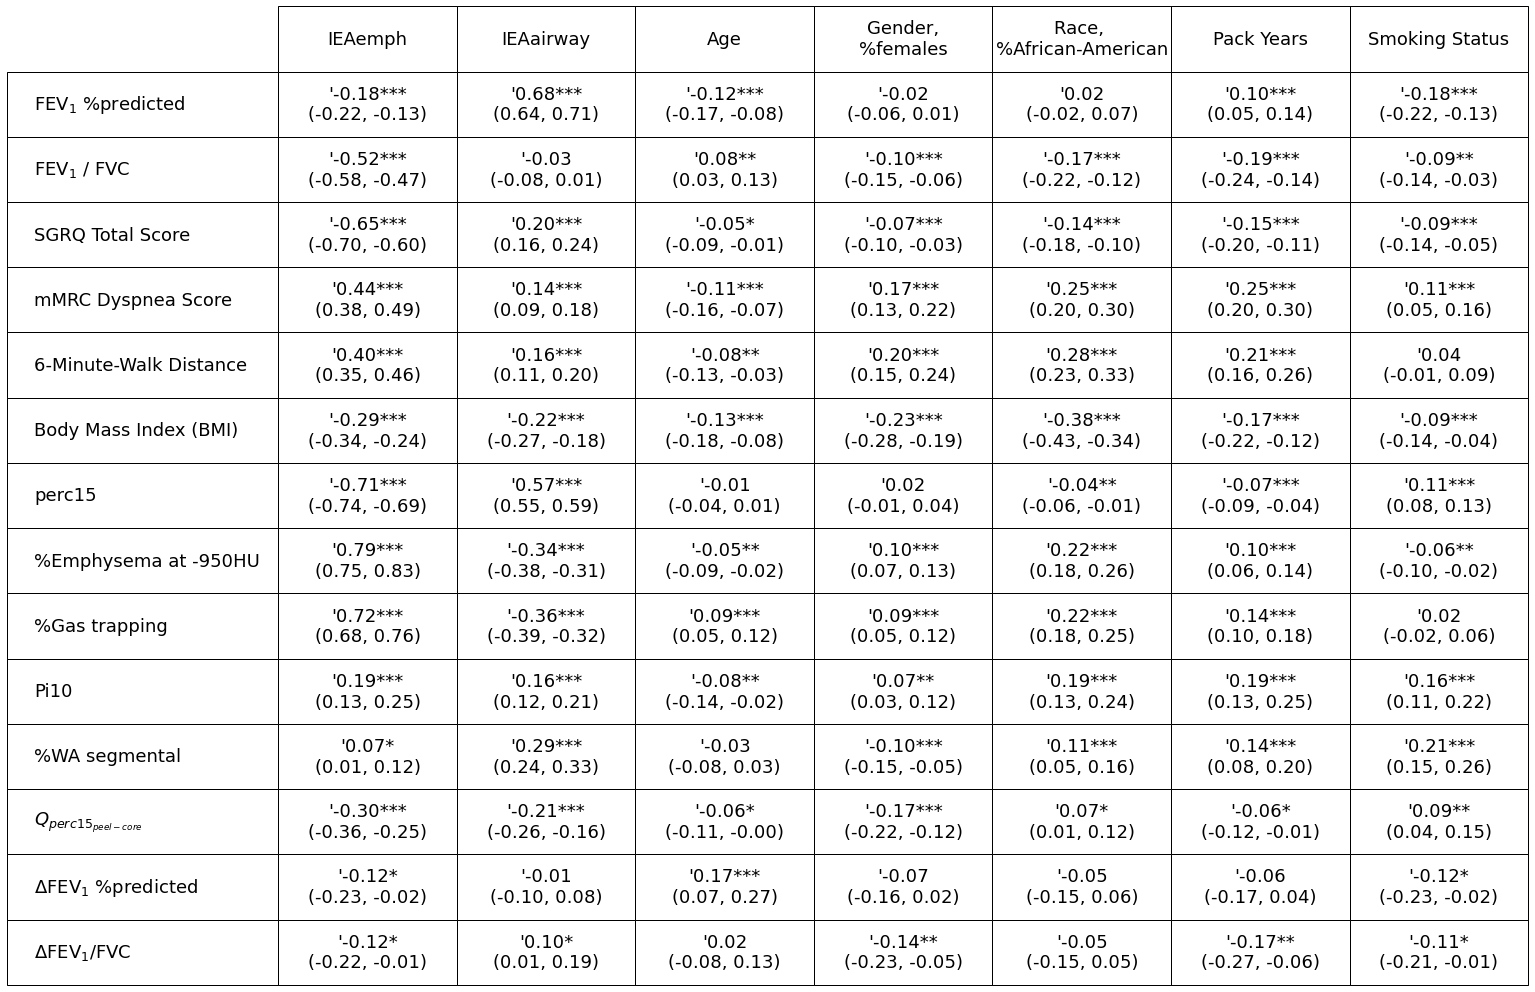

In [12]:
fig, ax = plt.subplots(figsize=(16,12))

the_table=plt.table(cellText=table, rowLabels=rows,
                    colLabels = cov_label,
                     colWidths = [.1]*table.shape[1], loc='center', fontsize = 50, cellLoc = "center"
                   )

plt.axis('off')

the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)

for iii in range(table.shape[0] + 1):
    for jjj in range(-1, table.shape[1]):
        if not (iii == 0 and jjj == -1) :
            the_table[(iii,jjj)].set_height(.1)
    